In [4]:
from tools.utils import *
from tools.het_networks import *

import torch

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Random
seed = 42

# Model
hidden_channels_list = [32, 64, 128, 256, 512]
# hidden_channels = 128 varying
num_classes = 6
num_layers = 2
intra_aggr='mean'
inter_aggr='sum'
dropout = 0.5
use_skip_connections = True

# Training
batch_size = 32
epochs = 30
decay = 1e-4
lr = 1e-4
maxlr = 3e-4

# Experiments iteration
i = 0

# Preprocessing

In [6]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features

In [7]:
def normalize_enzymes_data(data):
    data = data.clone()
    if hasattr(data, 'x') and data.x is not None:
        x = data.x
        feats = x[:, :18]
        mean = feats.mean(dim=0)
        std = feats.std(dim=0, unbiased=False)
        std[std == 0] = 1.0
        normalized_feats = (feats - mean) / std
        x[:, :18] = normalized_feats
        data.x = x
    return data

# Normalize features
normalized_hom_dataset_attr = [normalize_enzymes_data(hom_data) for hom_data in hom_dataset_attr]

In [8]:
# Construct het dataset
het_dataset = []
for hom_data in normalized_hom_dataset_attr:
    het_data = convert_hom_to_het(hom_data, onehot_indices=[18, 19, 20], is_directed=False)
    het_dataset.append(het_data)
het_dataset.__len__()

600

In [9]:
# Get the metadata to build HeteroGNN
edge_types = het_dataset[0].edge_types
node_types = het_dataset[0].node_types
metadata = (node_types, edge_types)
metadata

(['A', 'B', 'C'],
 [('A', 'edge_index', 'A'),
  ('A', 'edge_index', 'B'),
  ('A', 'edge_index', 'C'),
  ('B', 'edge_index', 'B'),
  ('B', 'edge_index', 'C'),
  ('C', 'edge_index', 'C')])

In [10]:
# Create splits
labels = [data.y.item() for data in het_dataset]

train_set, temp_set = train_test_split(
    het_dataset, 
    test_size=0.3, 
    stratify=labels,
    random_state=seed
    
)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=seed
)

# train_loader is defined at each experiment for reproducibility
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# 32 hidden_channels GraphConv

Epoch 1/30
Train Loss: 1.8092 | Validation Loss: 1.7953
Train Acc: 0.1500 | Validation Acc: 0.1778
Train F1: 0.0764 | Validation F1: 0.0689

Epoch 2/30
Train Loss: 1.8034 | Validation Loss: 1.7949
Train Acc: 0.1762 | Validation Acc: 0.1778
Train F1: 0.0972 | Validation F1: 0.0689

Epoch 3/30
Train Loss: 1.8011 | Validation Loss: 1.7943
Train Acc: 0.1667 | Validation Acc: 0.1778
Train F1: 0.0785 | Validation F1: 0.0689

Epoch 4/30
Train Loss: 1.8036 | Validation Loss: 1.7933
Train Acc: 0.1667 | Validation Acc: 0.1778
Train F1: 0.0838 | Validation F1: 0.0689

Epoch 5/30
Train Loss: 1.8038 | Validation Loss: 1.7915
Train Acc: 0.1619 | Validation Acc: 0.1778
Train F1: 0.0744 | Validation F1: 0.0689

Epoch 6/30
Train Loss: 1.7887 | Validation Loss: 1.7893
Train Acc: 0.1976 | Validation Acc: 0.1778
Train F1: 0.1133 | Validation F1: 0.0694

Epoch 7/30
Train Loss: 1.7914 | Validation Loss: 1.7869
Train Acc: 0.1810 | Validation Acc: 0.1778
Train F1: 0.1297 | Validation F1: 0.0865

Epoch 8/30
Tr

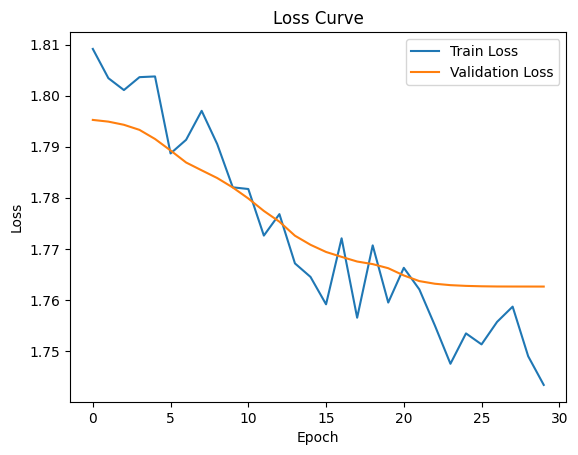

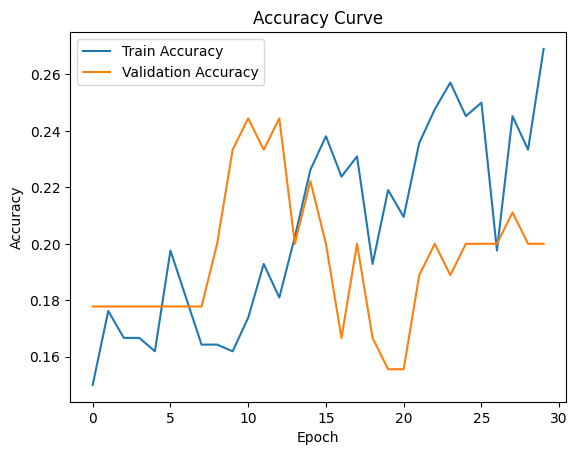

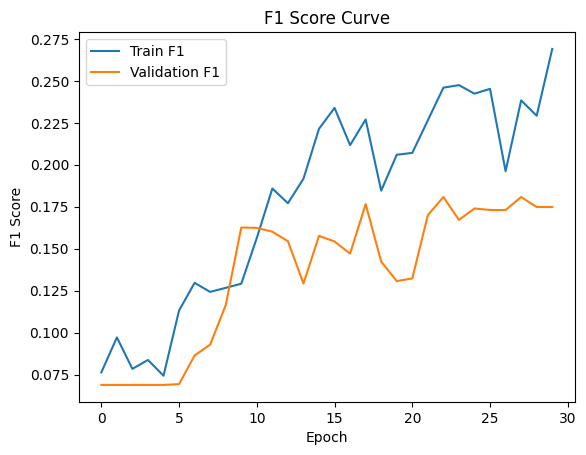

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8092,1.7953,0.1500,0.1778,0.0764,0.0689
1,2,1.8034,1.7949,0.1762,0.1778,0.0972,0.0689
2,3,1.8011,1.7943,0.1667,0.1778,0.0785,0.0689
3,4,1.8036,1.7933,0.1667,0.1778,0.0838,0.0689
4,5,1.8038,1.7915,0.1619,0.1778,0.0744,0.0689
5,6,1.7887,1.7893,0.1976,0.1778,0.1133,0.0694
6,7,1.7914,1.7869,0.1810,0.1778,0.1297,0.0865
7,8,1.7970,1.7854,0.1643,0.1778,0.1243,0.0929
8,9,1.7905,1.7839,0.1643,0.2000,0.1267,0.1164
9,10,1.7821,1.7820,0.1619,0.2333,0.1292,0.1626


In [11]:
hidden_channels = hidden_channels_list[i]
i += 1

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 64 hidden_channels GraphConv

Epoch 1/30
Train Loss: 1.8005 | Validation Loss: 1.7943
Train Acc: 0.1524 | Validation Acc: 0.1889
Train F1: 0.1288 | Validation F1: 0.0999

Epoch 2/30
Train Loss: 1.7921 | Validation Loss: 1.7940
Train Acc: 0.1524 | Validation Acc: 0.2000
Train F1: 0.1203 | Validation F1: 0.1045

Epoch 3/30
Train Loss: 1.7967 | Validation Loss: 1.7931
Train Acc: 0.1714 | Validation Acc: 0.1889
Train F1: 0.1280 | Validation F1: 0.0849

Epoch 4/30
Train Loss: 1.8024 | Validation Loss: 1.7916
Train Acc: 0.1405 | Validation Acc: 0.1889
Train F1: 0.1134 | Validation F1: 0.0849

Epoch 5/30
Train Loss: 1.7983 | Validation Loss: 1.7894
Train Acc: 0.1595 | Validation Acc: 0.2000
Train F1: 0.1269 | Validation F1: 0.1049

Epoch 6/30
Train Loss: 1.7921 | Validation Loss: 1.7873
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.1521 | Validation F1: 0.1181

Epoch 7/30
Train Loss: 1.7846 | Validation Loss: 1.7838
Train Acc: 0.1643 | Validation Acc: 0.1667
Train F1: 0.1517 | Validation F1: 0.0743

Epoch 8/30
Tr

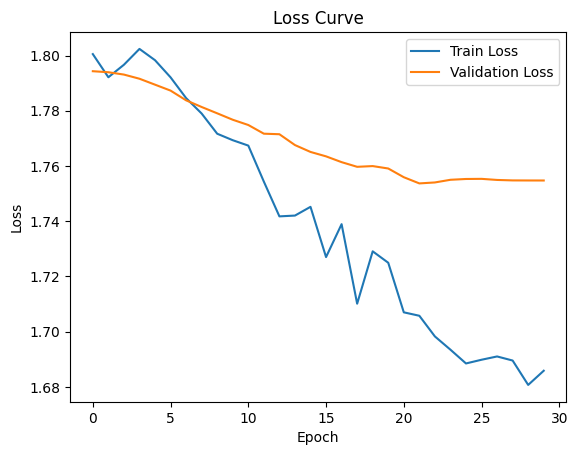

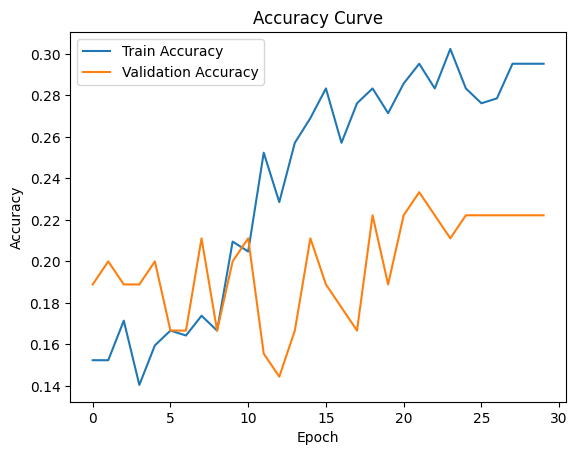

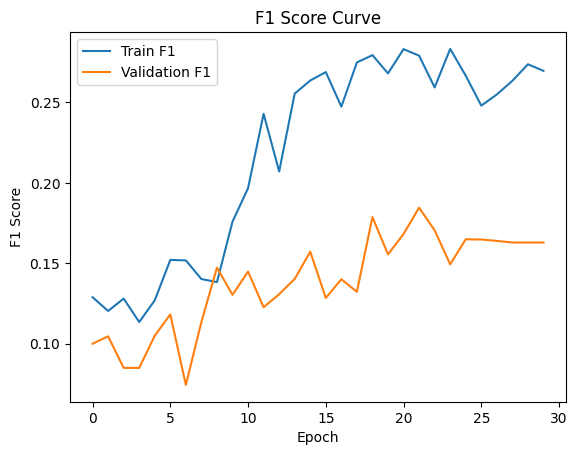

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8005,1.7943,0.1524,0.1889,0.1288,0.0999
1,2,1.7921,1.7940,0.1524,0.2000,0.1203,0.1045
2,3,1.7967,1.7931,0.1714,0.1889,0.1280,0.0849
3,4,1.8024,1.7916,0.1405,0.1889,0.1134,0.0849
4,5,1.7983,1.7894,0.1595,0.2000,0.1269,0.1049
5,6,1.7921,1.7873,0.1667,0.1667,0.1521,0.1181
6,7,1.7846,1.7838,0.1643,0.1667,0.1517,0.0743
7,8,1.7790,1.7814,0.1738,0.2111,0.1401,0.1135
8,9,1.7717,1.7791,0.1667,0.1667,0.1383,0.1472
9,10,1.7693,1.7767,0.2095,0.2000,0.1759,0.1303


In [12]:
hidden_channels = hidden_channels_list[i]
i += 1

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 128 hidden_channels GraphConv

Epoch 1/30
Train Loss: 1.8079 | Validation Loss: 1.7982
Train Acc: 0.1381 | Validation Acc: 0.1333
Train F1: 0.1022 | Validation F1: 0.0575

Epoch 2/30
Train Loss: 1.7913 | Validation Loss: 1.7967
Train Acc: 0.1833 | Validation Acc: 0.1333
Train F1: 0.1380 | Validation F1: 0.0600

Epoch 3/30
Train Loss: 1.7948 | Validation Loss: 1.7937
Train Acc: 0.1810 | Validation Acc: 0.1556
Train F1: 0.1341 | Validation F1: 0.0636

Epoch 4/30
Train Loss: 1.7908 | Validation Loss: 1.7896
Train Acc: 0.1833 | Validation Acc: 0.1667
Train F1: 0.1499 | Validation F1: 0.0963

Epoch 5/30
Train Loss: 1.7871 | Validation Loss: 1.7851
Train Acc: 0.1690 | Validation Acc: 0.1333
Train F1: 0.1523 | Validation F1: 0.1054

Epoch 6/30
Train Loss: 1.7786 | Validation Loss: 1.7794
Train Acc: 0.1738 | Validation Acc: 0.1778
Train F1: 0.1693 | Validation F1: 0.1011

Epoch 7/30
Train Loss: 1.7670 | Validation Loss: 1.7706
Train Acc: 0.1929 | Validation Acc: 0.2222
Train F1: 0.1760 | Validation F1: 0.1299

Epoch 8/30
Tr

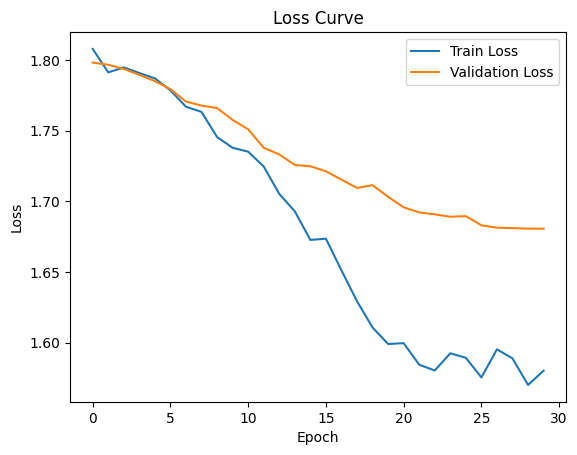

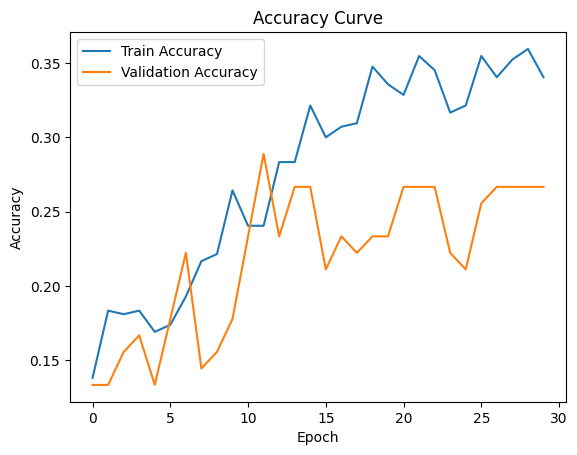

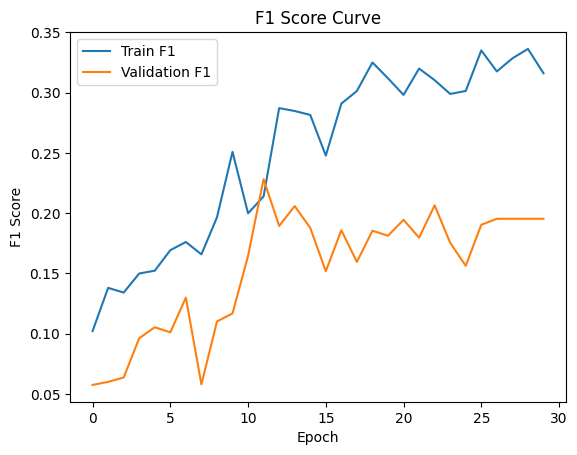

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8079,1.7982,0.1381,0.1333,0.1022,0.0575
1,2,1.7913,1.7967,0.1833,0.1333,0.1380,0.0600
2,3,1.7948,1.7937,0.1810,0.1556,0.1341,0.0636
3,4,1.7908,1.7896,0.1833,0.1667,0.1499,0.0963
4,5,1.7871,1.7851,0.1690,0.1333,0.1523,0.1054
5,6,1.7786,1.7794,0.1738,0.1778,0.1693,0.1011
6,7,1.7670,1.7706,0.1929,0.2222,0.1760,0.1299
7,8,1.7633,1.7678,0.2167,0.1444,0.1658,0.0580
8,9,1.7455,1.7660,0.2214,0.1556,0.1965,0.1101
9,10,1.7379,1.7576,0.2643,0.1778,0.2508,0.1168


In [13]:
hidden_channels = hidden_channels_list[i]
i += 1

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 256 hidden_channels GraphConv

Epoch 1/30
Train Loss: 1.8080 | Validation Loss: 1.7977
Train Acc: 0.1524 | Validation Acc: 0.1556
Train F1: 0.0724 | Validation F1: 0.0453

Epoch 2/30
Train Loss: 1.7995 | Validation Loss: 1.7937
Train Acc: 0.1714 | Validation Acc: 0.1778
Train F1: 0.1219 | Validation F1: 0.0876

Epoch 3/30
Train Loss: 1.7900 | Validation Loss: 1.7885
Train Acc: 0.1952 | Validation Acc: 0.1889
Train F1: 0.1826 | Validation F1: 0.1511

Epoch 4/30
Train Loss: 1.7837 | Validation Loss: 1.7827
Train Acc: 0.1762 | Validation Acc: 0.2111
Train F1: 0.1573 | Validation F1: 0.1152

Epoch 5/30
Train Loss: 1.7784 | Validation Loss: 1.7725
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.1405 | Validation F1: 0.1361

Epoch 6/30
Train Loss: 1.7530 | Validation Loss: 1.7630
Train Acc: 0.2381 | Validation Acc: 0.2333
Train F1: 0.2143 | Validation F1: 0.1647

Epoch 7/30
Train Loss: 1.7442 | Validation Loss: 1.7448
Train Acc: 0.2500 | Validation Acc: 0.2111
Train F1: 0.2132 | Validation F1: 0.1563

Epoch 8/30
Tr

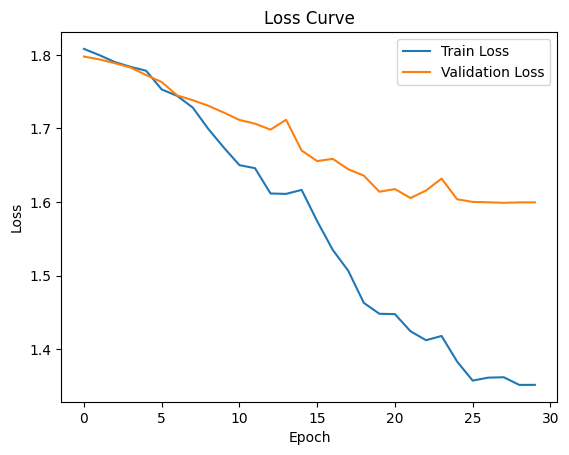

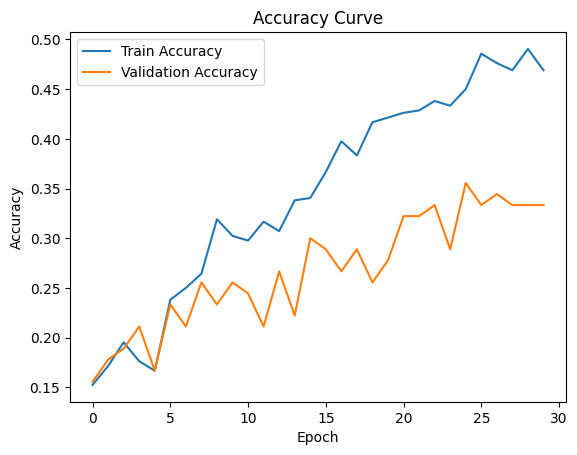

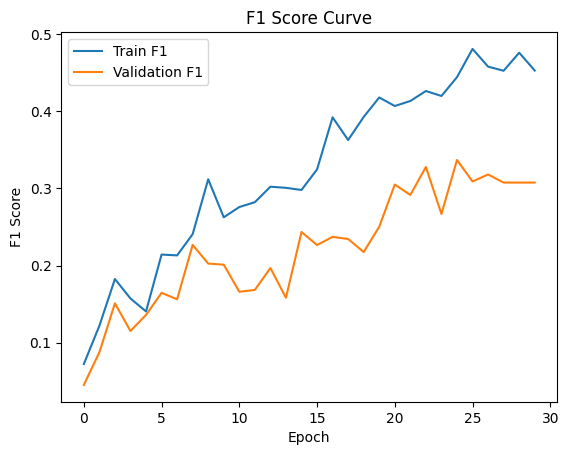

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8080,1.7977,0.1524,0.1556,0.0724,0.0453
1,2,1.7995,1.7937,0.1714,0.1778,0.1219,0.0876
2,3,1.7900,1.7885,0.1952,0.1889,0.1826,0.1511
3,4,1.7837,1.7827,0.1762,0.2111,0.1573,0.1152
4,5,1.7784,1.7725,0.1667,0.1667,0.1405,0.1361
5,6,1.7530,1.7630,0.2381,0.2333,0.2143,0.1647
6,7,1.7442,1.7448,0.2500,0.2111,0.2132,0.1563
7,8,1.7283,1.7383,0.2643,0.2556,0.2407,0.2268
8,9,1.6993,1.7308,0.3190,0.2333,0.3118,0.2026
9,10,1.6740,1.7215,0.3024,0.2556,0.2625,0.2012


In [14]:
hidden_channels = hidden_channels_list[i]
i += 1

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 512 hidden_channels GraphConv

Epoch 1/30
Train Loss: 1.7971 | Validation Loss: 1.7825
Train Acc: 0.1833 | Validation Acc: 0.2222
Train F1: 0.1130 | Validation F1: 0.1253

Epoch 2/30
Train Loss: 1.7868 | Validation Loss: 1.7781
Train Acc: 0.2167 | Validation Acc: 0.2889
Train F1: 0.1671 | Validation F1: 0.2241

Epoch 3/30
Train Loss: 1.7823 | Validation Loss: 1.7706
Train Acc: 0.1667 | Validation Acc: 0.1889
Train F1: 0.1316 | Validation F1: 0.0880

Epoch 4/30
Train Loss: 1.7658 | Validation Loss: 1.7561
Train Acc: 0.2000 | Validation Acc: 0.2556
Train F1: 0.1473 | Validation F1: 0.1493

Epoch 5/30
Train Loss: 1.7458 | Validation Loss: 1.7376
Train Acc: 0.2405 | Validation Acc: 0.2667
Train F1: 0.2183 | Validation F1: 0.2131

Epoch 6/30
Train Loss: 1.7209 | Validation Loss: 1.7238
Train Acc: 0.3024 | Validation Acc: 0.2778
Train F1: 0.2652 | Validation F1: 0.2062

Epoch 7/30
Train Loss: 1.7062 | Validation Loss: 1.7111
Train Acc: 0.3000 | Validation Acc: 0.2667
Train F1: 0.2671 | Validation F1: 0.2005

Epoch 8/30
Tr

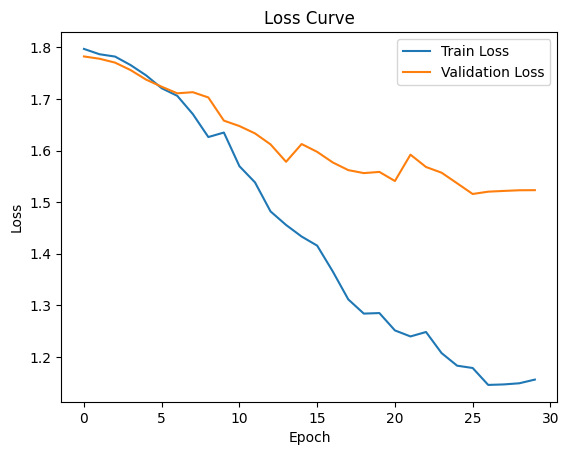

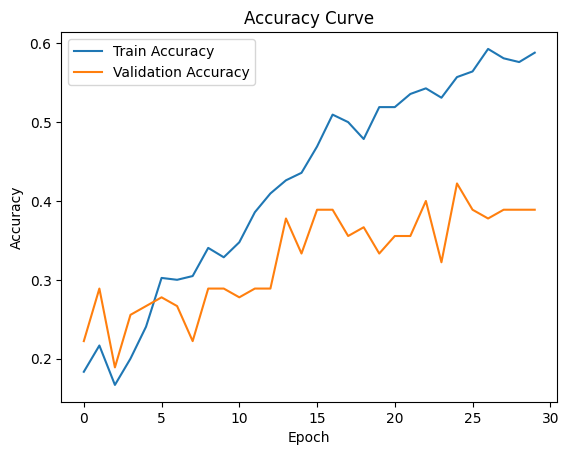

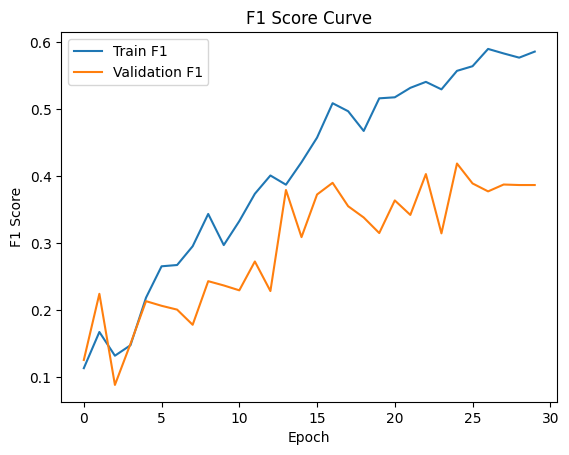

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7971,1.7825,0.1833,0.2222,0.1130,0.1253
1,2,1.7868,1.7781,0.2167,0.2889,0.1671,0.2241
2,3,1.7823,1.7706,0.1667,0.1889,0.1316,0.0880
3,4,1.7658,1.7561,0.2000,0.2556,0.1473,0.1493
4,5,1.7458,1.7376,0.2405,0.2667,0.2183,0.2131
5,6,1.7209,1.7238,0.3024,0.2778,0.2652,0.2062
6,7,1.7062,1.7111,0.3000,0.2667,0.2671,0.2005
7,8,1.6709,1.7132,0.3048,0.2222,0.2951,0.1778
8,9,1.6262,1.7030,0.3405,0.2889,0.3433,0.2429
9,10,1.6350,1.6580,0.3286,0.2889,0.2968,0.2366


In [15]:
hidden_channels = hidden_channels_list[i]
i += 1

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)